In [1]:
import os
from pathlib import Path

# Define dataset path
dataset_path = Path("dataset/Images")

# List all subdirectories (each subdirectory corresponds to a dog breed)
breed_directories = [d.name for d in dataset_path.iterdir() if d.is_dir()]

print(f"Total breeds: {len(breed_directories)}")
print(f"First 5 breeds: {breed_directories[:5]}")

# Count the number of images per breed
image_count_per_breed = {breed: len(list((dataset_path / breed).glob("*.jpg"))) for breed in breed_directories}
print(f"Example image counts: {list(image_count_per_breed.items())[:5]}")


Total breeds: 120
First 5 breeds: ['n02097658-silky_terrier', 'n02092002-Scottish_deerhound', 'n02099849-Chesapeake_Bay_retriever', 'n02091244-Ibizan_hound', 'n02095314-wire-haired_fox_terrier']
Example image counts: [('n02097658-silky_terrier', 183), ('n02092002-Scottish_deerhound', 232), ('n02099849-Chesapeake_Bay_retriever', 167), ('n02091244-Ibizan_hound', 188), ('n02095314-wire-haired_fox_terrier', 157)]


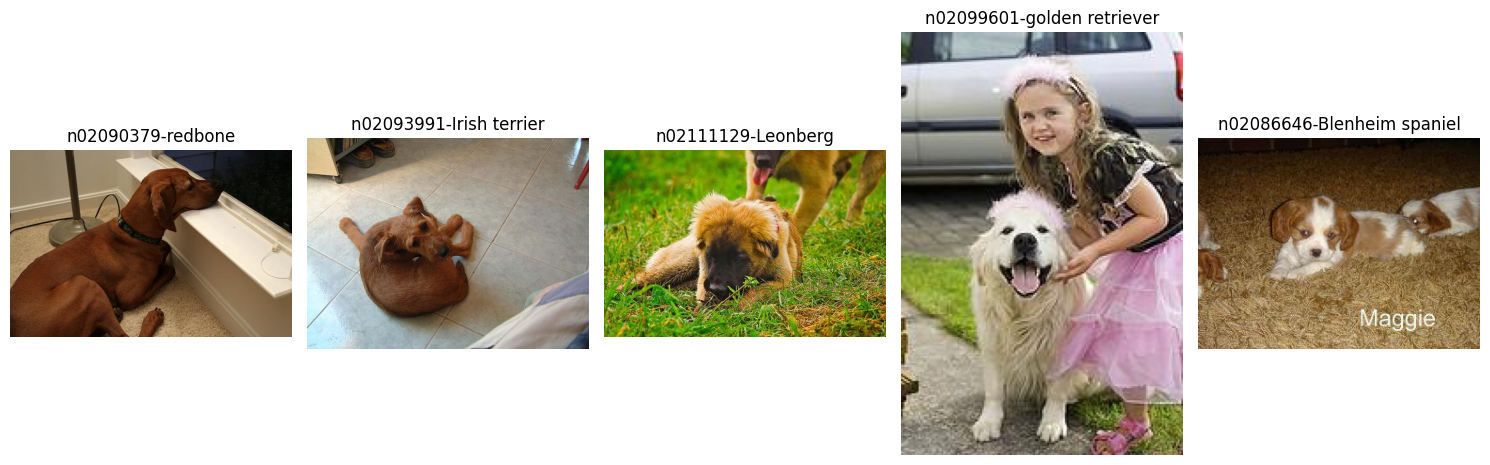

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import random

# Helper function to display sample images
def display_sample_images(dataset_path, breed_directories, num_samples=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        breed = random.choice(breed_directories)
        breed_path = dataset_path / breed
        image_file = random.choice(list(breed_path.glob("*.jpg")))
        img = Image.open(image_file)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(breed.replace("_", " "))
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Display sample images
display_sample_images(dataset_path, breed_directories)


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image dimensions
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Define data augmentation
data_gen = ImageDataGenerator(
    rescale=1.0/255.0,           # Normalize pixel values to [0, 1]
    validation_split=0.2,        # Split data into training and validation sets
    rotation_range=30,           # Randomly rotate images by up to 30 degrees
    width_shift_range=0.2,       # Randomly shift images horizontally
    height_shift_range=0.2,      # Randomly shift images vertically
    shear_range=0.2,             # Shear transformation
    zoom_range=0.2,              # Zoom in/out
    horizontal_flip=True         # Randomly flip images horizontally
)

# Create training data generator
train_data_gen = data_gen.flow_from_directory(
    dataset_path,                # Path to dataset
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Resize images
    batch_size=32,               # Number of images per batch
    class_mode='categorical',    # One-hot encoding for multi-class classification
    subset='training'            # Specify training subset
)

# Create validation data generator
validation_data_gen = data_gen.flow_from_directory(
    dataset_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='categorical',
    subset='validation'          # Specify validation subset
)


Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


Class indices: {'n02085620-Chihuahua': 0, 'n02085782-Japanese_spaniel': 1, 'n02085936-Maltese_dog': 2, 'n02086079-Pekinese': 3, 'n02086240-Shih-Tzu': 4, 'n02086646-Blenheim_spaniel': 5, 'n02086910-papillon': 6, 'n02087046-toy_terrier': 7, 'n02087394-Rhodesian_ridgeback': 8, 'n02088094-Afghan_hound': 9, 'n02088238-basset': 10, 'n02088364-beagle': 11, 'n02088466-bloodhound': 12, 'n02088632-bluetick': 13, 'n02089078-black-and-tan_coonhound': 14, 'n02089867-Walker_hound': 15, 'n02089973-English_foxhound': 16, 'n02090379-redbone': 17, 'n02090622-borzoi': 18, 'n02090721-Irish_wolfhound': 19, 'n02091032-Italian_greyhound': 20, 'n02091134-whippet': 21, 'n02091244-Ibizan_hound': 22, 'n02091467-Norwegian_elkhound': 23, 'n02091635-otterhound': 24, 'n02091831-Saluki': 25, 'n02092002-Scottish_deerhound': 26, 'n02092339-Weimaraner': 27, 'n02093256-Staffordshire_bullterrier': 28, 'n02093428-American_Staffordshire_terrier': 29, 'n02093647-Bedlington_terrier': 30, 'n02093754-Border_terrier': 31, 'n0209

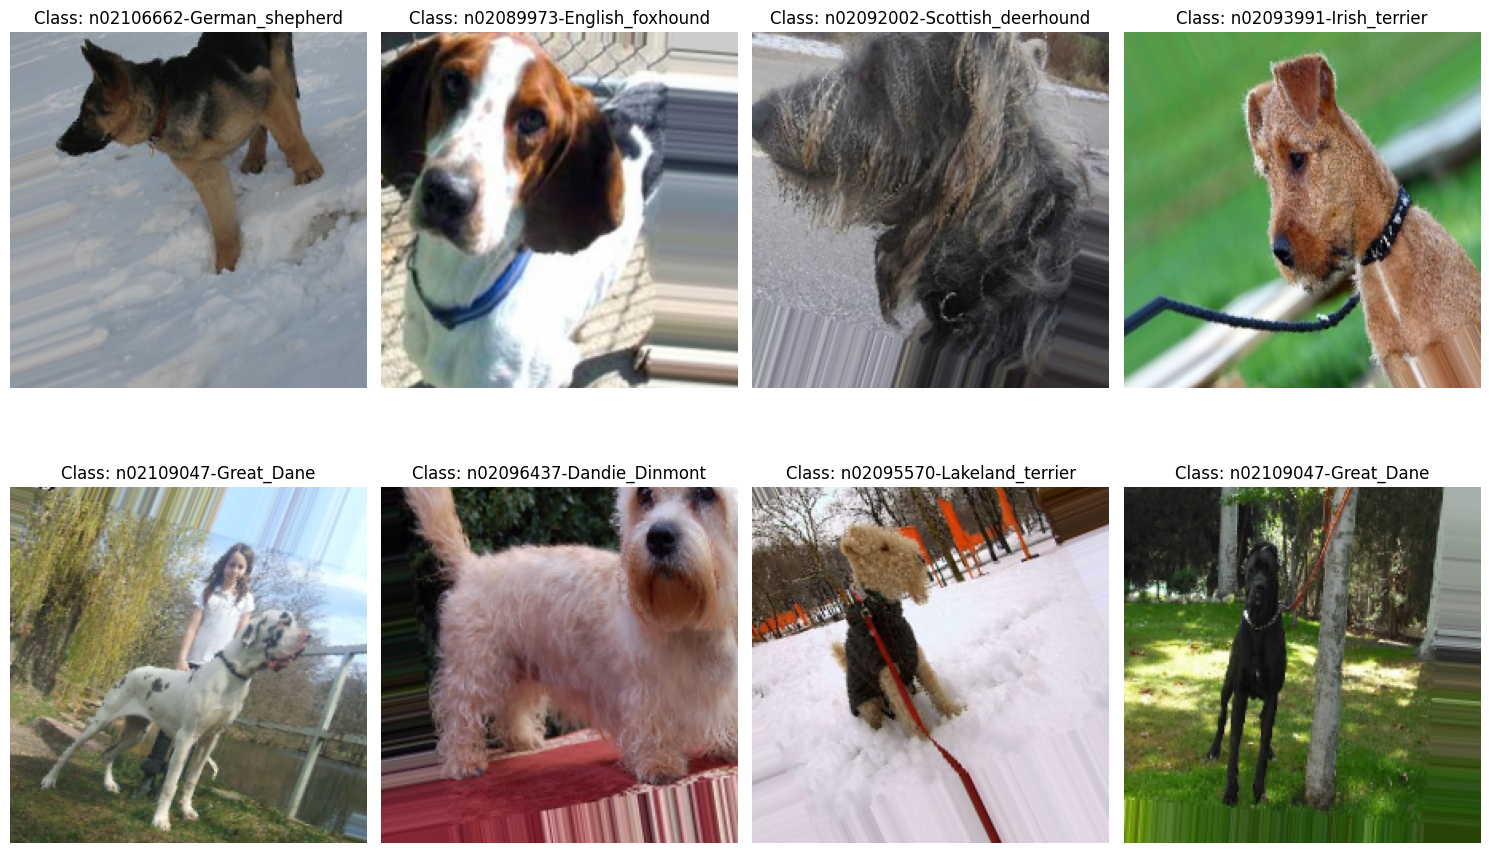

In [4]:
# Inspect the class labels
print(f"Class indices: {train_data_gen.class_indices}")

# Visualize a batch of training images
def visualize_batch(data_gen):
    images, labels = next(data_gen)  # Get a batch of images and labels
    plt.figure(figsize=(15, 10))
    for i in range(8):  # Display the first 8 images
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i])
        plt.title(f"Class: {list(train_data_gen.class_indices.keys())[labels[i].argmax()]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

visualize_batch(train_data_gen)


In [5]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load the pretrained model without the top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

base_model.trainable = False


# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dropout(0.5)(x)              # Dropout for regularization
x = Dense(256, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)              # Dropout for regularization
predictions = Dense(len(train_data_gen.class_indices), activation='softmax')(x)  # Output layer

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,616,760 (9.98 MB)

 Trainable params: 358,776 (1.37 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [6]:
# Train the model
history = model.fit(
    train_data_gen,
    validation_data=validation_data_gen,
    epochs=10,  # Adjust epochs based on performance
    verbose=1
)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 159s 303ms/step - accuracy: 0.1223 - loss: 4.0750 - val_accuracy: 0.5678 - val_loss: 1.6771
Epoch 2/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 152s 294ms/step - accuracy: 0.4173 - loss: 2.1940 - val_accuracy: 0.5975 - val_loss: 1.4685
Epoch 3/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 152s 293ms/step - accuracy: 0.4732 - loss: 1.9109 - val_accuracy: 0.6054 - val_loss: 1.4003
Epoch 4/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 154s 298ms/step - accuracy: 0.4938 - loss: 1.8358 - val_accuracy: 0.6194 - val_loss: 1.3759
Epoch 5/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 153s 296ms/step - accuracy: 0.5055 - loss: 1.7623 - val_accuracy: 0.6115 - val_loss: 1.3690
Epoch 6/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 153s 296ms/step - accuracy: 0.5169 - loss: 1.7270 - val_accuracy: 0.6139 - val_loss: 1.3551
Epoch 7/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 153s 296ms/step - accuracy: 0.5278 - loss: 1.6737 - val_accuracy: 0.6196 - val_loss: 1.3364
Epoch 8/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 153s 296ms/step - accuracy: 0.5347 -

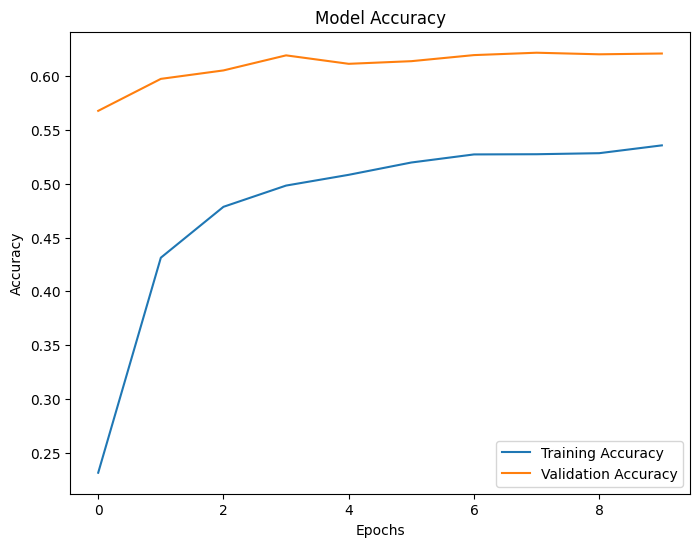

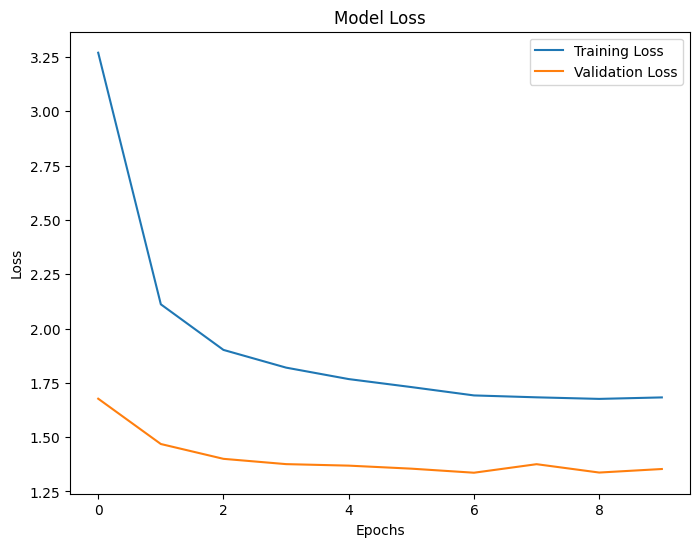

In [7]:
# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
Predicted Breed: n02086240-Shih-Tzu
Confidence: 0.79


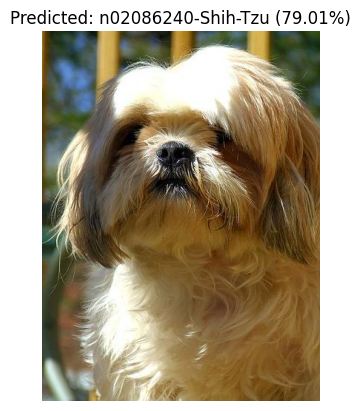

In [8]:
import numpy as np
from tensorflow.keras.preprocessing import image

def preprocess_image(img_path):
    # Load the image
    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    
    # Convert to numpy array
    img_array = image.img_to_array(img)
    
    # Rescale pixel values (same as during training)
    img_array = img_array / 255.0
    
    # Add a batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array

def predict_breed(img_path, model, class_indices):
    # Preprocess the image
    img_array = preprocess_image(img_path)
    
    # Make a prediction
    predictions = model.predict(img_array)
    
    # Get the class index with the highest probability
    predicted_class = np.argmax(predictions[0])
    
    # Get the breed name
    breed_name = list(class_indices.keys())[list(class_indices.values()).index(predicted_class)]
    
    return breed_name, predictions[0][predicted_class]


# Test with a new image
test_image_path = "dataset/Images/n02086240-Shih-Tzu/n02086240_61.jpg"

# Get class indices from the data generator
class_indices = train_data_gen.class_indices

# Predict the breed
predicted_breed, confidence = predict_breed(test_image_path, model, class_indices)

print(f"Predicted Breed: {predicted_breed}")
print(f"Confidence: {confidence:.2f}")

# Visualize the input image along with the prediction
import matplotlib.pyplot as plt
from PIL import Image

img = Image.open(test_image_path)
plt.imshow(img)
plt.title(f"Predicted: {predicted_breed} ({confidence*100:.2f}%)")
plt.axis("off")
plt.show()
